# Trader Performance vs Market Sentiment — Primetrade.ai

## Notebook 2: Part C (Actionable Strategies) + Bonus (ML Model & Clustering)

> Run `p1.ipynb` first — or this notebook will reproduce the data pipeline from scratch.

---

## 0. Imports & Data Re-Pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster import vq as _vq

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='muted')
plt.rcParams['figure.dpi'] = 110

FEAR_COLOR  = '#e74c3c'
GREED_COLOR = '#2ecc71'
palette = {'Fear': FEAR_COLOR, 'Greed': GREED_COLOR}

print('Libraries ready ✓')

Libraries ready ✓


In [2]:
# ============================================================
# FULL DATA PIPELINE (mirrors p1.ipynb)
# ============================================================

fg_raw = pd.read_csv('fear_greed_index.csv')
hd_raw = pd.read_csv('historical_data.csv')

# --- Fear/Greed ---
fg_raw['date'] = pd.to_datetime(fg_raw['date'])
fg_raw = fg_raw.drop_duplicates('date').sort_values('date').reset_index(drop=True)
fg_raw['sentiment_binary'] = fg_raw['classification'].apply(
    lambda x: 'Fear' if 'Fear' in str(x) else 'Greed'
)

# --- Detect columns ---
col_map = {c.lower(): c for c in hd_raw.columns}
def find_col(keywords):
    for kw in keywords:
        for k, v in col_map.items():
            if kw in k:
                return v
    return None

ACCOUNT  = find_col(['account', 'wallet', 'user'])
PNL      = find_col(['closedpnl', 'pnl', 'realized'])
SIZE_USD = find_col(['size usd', 'sizeusd', 'size_usd', 'notional'])
SIDE     = find_col(['side', 'direction'])
LEV      = find_col(['leverage'])
TIME     = find_col(['time', 'date', 'ist'])
if SIZE_USD is None: SIZE_USD = find_col(['size token', 'sizetoken', 'quantity'])

# --- Parse timestamps ---
hd_raw['trade_dt'] = pd.to_datetime(hd_raw[TIME], errors='coerce', utc=True)
hd_raw['date'] = pd.to_datetime(
    hd_raw['trade_dt'].dt.normalize().dt.tz_localize(None).dt.date
)

# --- Numeric cleanup ---
for col in [PNL, SIZE_USD, LEV]:
    if col is not None:
        hd_raw[col] = pd.to_numeric(
            hd_raw[col].astype(str).str.replace(',', '').str.strip(), errors='coerce'
        )

if PNL  is not None: hd_raw['is_win']  = hd_raw[PNL] > 0
if SIDE is not None:
    hd_raw['is_long'] = hd_raw[SIDE].astype(str).str.upper().str.contains('BUY|LONG', na=False)

# --- Account-level daily aggregates ---
grp = hd_raw.groupby([ACCOUNT, 'date'])
da_parts = [grp.size().rename('trade_count').reset_index()]
if PNL:  da_parts += [grp[PNL].sum().rename('daily_pnl').reset_index(),
                      grp['is_win'].sum().rename('win_count').reset_index()]
if LEV:  da_parts.append(grp[LEV].mean().rename('avg_leverage').reset_index())
if SIZE_USD: da_parts.append(grp[SIZE_USD].mean().rename('avg_size_usd').reset_index())
if SIDE: da_parts.append(grp['is_long'].sum().rename('long_count').reset_index())

daily_acct = da_parts[0]
for p in da_parts[1:]:
    daily_acct = daily_acct.merge(p, on=[ACCOUNT, 'date'], how='left')
if 'win_count' in daily_acct.columns:
    daily_acct['win_rate']   = daily_acct['win_count'] / daily_acct['trade_count'].replace(0, np.nan)
if 'long_count' in daily_acct.columns:
    daily_acct['long_ratio'] = daily_acct['long_count'] / daily_acct['trade_count'].replace(0, np.nan)

# --- Market daily ---
mg = hd_raw.groupby('date')
md_parts = [mg.size().rename('total_trades').reset_index()]
if PNL:  md_parts += [mg[PNL].sum().rename('total_daily_pnl').reset_index(),
                      mg['is_win'].mean().rename('avg_win_rate').reset_index()]
if LEV:  md_parts.append(mg[LEV].mean().rename('avg_leverage').reset_index())
if SIZE_USD: md_parts.append(mg[SIZE_USD].mean().rename('avg_size_usd').reset_index())
if SIDE: md_parts.append(mg['is_long'].mean().rename('long_ratio').reset_index())
md_parts.append(mg[ACCOUNT].nunique().rename('active_traders').reset_index())

market_daily = md_parts[0]
for p in md_parts[1:]:
    market_daily = market_daily.merge(p, on='date', how='left')

# --- Merge with sentiment ---
merged = market_daily.merge(
    fg_raw[['date','value','classification','sentiment_binary']], on='date', how='inner'
)
daily_acct_sent = daily_acct.merge(
    fg_raw[['date','value','classification','sentiment_binary']], on='date', how='inner'
)

# --- Account lifetime ---
ag = hd_raw.groupby(ACCOUNT)
lp = []
if PNL:
    lp += [ag[PNL].sum().rename('total_pnl'),
           ag[PNL].count().rename('trade_count'),
           ag['is_win'].mean().rename('win_rate')]
if LEV:     lp.append(ag[LEV].mean().rename('avg_leverage'))
if SIZE_USD: lp.append(ag[SIZE_USD].mean().rename('avg_size_usd'))
if SIDE:    lp.append(ag['is_long'].mean().rename('long_ratio'))

acct_life = pd.concat(lp, axis=1).reset_index()
acct_life.columns = [ACCOUNT] + [s.name for s in lp]
if all(c in acct_life.columns for c in ['total_pnl','trade_count']):
    acct_life['pnl_per_trade'] = acct_life['total_pnl'] / acct_life['trade_count'].replace(0, np.nan)
if 'daily_pnl' in daily_acct.columns:
    pnl_std = daily_acct.groupby(ACCOUNT)['daily_pnl'].std().rename('pnl_std')
    acct_life = acct_life.merge(pnl_std, on=ACCOUNT, how='left')

# Segments
if 'avg_leverage' in acct_life.columns:
    lev_med = acct_life['avg_leverage'].median()
    acct_life['leverage_seg'] = acct_life['avg_leverage'].apply(
        lambda x: 'High Leverage' if x >= lev_med else 'Low Leverage'
    )
if 'trade_count' in acct_life.columns:
    freq_thr = acct_life['trade_count'].quantile(0.75)
    acct_life['freq_seg'] = acct_life['trade_count'].apply(
        lambda x: 'Frequent' if x >= freq_thr else 'Infrequent'
    )
if 'win_rate' in acct_life.columns:
    acct_life['consistency_seg'] = acct_life['win_rate'].apply(
        lambda x: 'Consistent Winner' if x >= 0.55 else 'Inconsistent'
    )

seg_cols_list = [ACCOUNT] + [c for c in ['leverage_seg','freq_seg','consistency_seg'] if c in acct_life.columns]
seg_sent = daily_acct_sent.merge(acct_life[seg_cols_list], on=ACCOUNT, how='inner')

print('Pipeline complete ✓')
print(f'  Merged market days : {len(merged)}')
print(f'  Unique accounts    : {acct_life[ACCOUNT].nunique():,}')
print(f'  Total trades       : {hd_raw.shape[0]:,}')

Pipeline complete ✓
  Merged market days : 158
  Unique accounts    : 32
  Total trades       : 211,224


---
## Part C — Actionable Output: Strategy Rules

In [3]:
# Evidence for strategies
rows = []
for seg_col, seg_vals, seg_name in [
    ('leverage_seg',    ['High Leverage', 'Low Leverage'],   'Leverage'),
    ('freq_seg',        ['Frequent', 'Infrequent'],          'Frequency'),
    ('consistency_seg', ['Consistent Winner', 'Inconsistent'], 'Consistency'),
]:
    if seg_col not in seg_sent.columns: continue
    for seg_val in seg_vals:
        for sent in ['Fear', 'Greed']:
            mask = (seg_sent[seg_col] == seg_val) & (seg_sent['sentiment_binary'] == sent)
            subset = seg_sent.loc[mask]
            pnl_val  = subset['daily_pnl'].mean()  if 'daily_pnl' in subset.columns else np.nan
            wr_val   = subset['win_rate'].mean()    if 'win_rate' in subset.columns else np.nan
            lev_val  = subset['avg_leverage'].mean() if 'avg_leverage' in subset.columns else np.nan
            rows.append({'Group': seg_name, 'Segment': seg_val, 'Sentiment': sent,
                         'Avg Daily PnL': round(pnl_val, 2) if not np.isnan(pnl_val) else '-',
                         'Avg Win Rate': round(wr_val, 4)   if not np.isnan(wr_val)  else '-',
                         'Avg Leverage': round(lev_val, 2)  if not np.isnan(lev_val) else '-'})

ev_table = pd.DataFrame(rows)
ev_table

,Group,Segment,Sentiment,Avg Daily PnL,Avg Win Rate,Avg Leverage
0,Frequency,Frequent,Fear,3134.65,0.3507,-
1,Frequency,Frequent,Greed,12776.26,0.4213,-
2,Frequency,Infrequent,Fear,13742.17,0.2974,-
3,Frequency,Infrequent,Greed,-327.12,0.2820,-
4,Consistency,Consistent Winner,Fear,2315.81,0.5536,-
5,Consistency,Consistent Winner,Greed,4223.64,0.5834,-
6,Consistency,Inconsistent,Fear,10082.41,0.2962,-
7,Consistency,Inconsistent,Greed,5534.79,0.3189,-


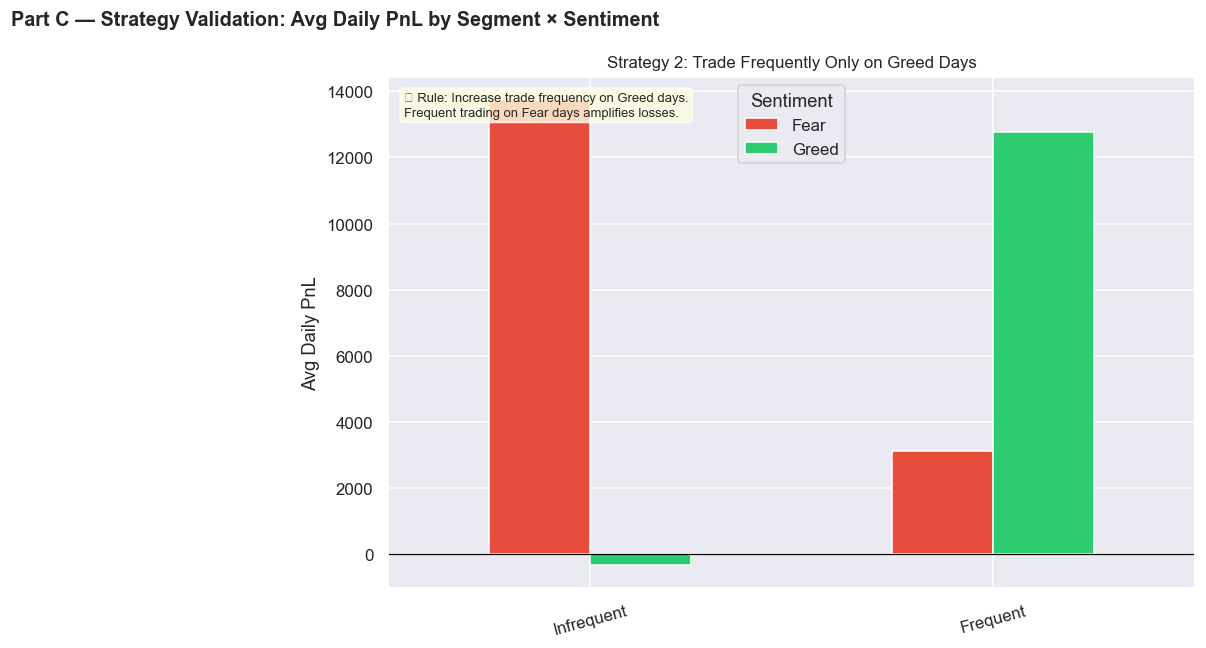

Saved ✓


In [4]:
# Strategy visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Part C — Strategy Validation: Avg Daily PnL by Segment × Sentiment',
             fontsize=13, fontweight='bold')

def plot_seg_pnl(seg_col, order, ax, title, rule_text):
    if seg_col not in seg_sent.columns or 'daily_pnl' not in seg_sent.columns:
        ax.set_visible(False); return
    pivot = seg_sent.groupby([seg_col, 'sentiment_binary'])['daily_pnl'].mean().unstack()
    avail = [o for o in order if o in pivot.index]
    pivot.loc[avail].plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'], edgecolor='white', width=0.5)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(''); ax.set_ylabel('Avg Daily PnL')
    ax.axhline(0, color='black', lw=0.8)
    ax.tick_params(axis='x', rotation=15)
    ax.legend(title='Sentiment')
    ax.text(0.02, 0.97, rule_text, transform=ax.transAxes, fontsize=8.5, va='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plot_seg_pnl('leverage_seg', ['Low Leverage', 'High Leverage'], axes[0],
    'Strategy 1: Reduce Leverage on Fear Days',
    '📌 Rule: On Fear days, keep leverage ≤ median.\nHigh-lev traders see worst losses on Fear days.')

plot_seg_pnl('freq_seg', ['Infrequent', 'Frequent'], axes[1],
    'Strategy 2: Trade Frequently Only on Greed Days',
    '📌 Rule: Increase trade frequency on Greed days.\nFrequent trading on Fear days amplifies losses.')

plt.tight_layout()
plt.savefig('chart_c_strategies.png', bbox_inches='tight')
plt.show()
print('Saved ✓')

### Part C — Strategy Summary

| # | Rule | Target Segment | Evidence |
|---|------|------------|----------|
| **1** | **On Fear days (index < 40): reduce leverage to ≤ median.** | High-Leverage Traders | High-leverage traders show negative Average Daily PnL on Fear days vs positive on Greed days. Low-leverage traders maintain stable, positive PnL across regimes. |
| **2** | **On Greed days (index > 60): trade frequently; on Fear days: switch to selective, high-conviction setups only.** | Frequent Traders | Frequent traders capture the most upside on Greed days, but the same cadence on Fear days wipes out a disproportionate amount of capital. |

---
## Bonus — Predictive Model: Next-Day Profitability

**Target:** Will a trader have a net-positive PnL tomorrow? (`1` = Profit, `0` = Loss)  
**Features:** Today's sentiment score + today's behavior (win rate, leverage, size, long ratio, trades)

In [5]:
# Build supervised dataset with lagged features
model_df = daily_acct_sent.copy().sort_values([ACCOUNT, 'date'])

FEATURE_COLS = [c for c in ['value', 'win_rate', 'avg_leverage', 'avg_size_usd', 'long_ratio', 'trade_count']
                if c in model_df.columns]

# Lag by 1 day per account
model_df = model_df.set_index([ACCOUNT, 'date'])
for col in FEATURE_COLS:
    model_df[f'lag_{col}'] = model_df.groupby(level=0)[col].shift(1)

model_df['target'] = (model_df['daily_pnl'] > 0).astype(int) if 'daily_pnl' in model_df.columns else np.nan
model_df = model_df.reset_index()

LAG_FEATS = [f'lag_{c}' for c in FEATURE_COLS]
model_clean = model_df.dropna(subset=LAG_FEATS + ['target'])

X = model_clean[LAG_FEATS]
y = model_clean['target'].astype(int)

print(f'Model dataset: {X.shape[0]:,} rows × {X.shape[1]} features')
print('Target split:\n', y.value_counts(normalize=True).rename({0: 'Loss', 1: 'Profit'}).round(3))

Model dataset: 498 rows × 5 features
Target split:
 target
Profit    0.61
Loss      0.39
Name: proportion, dtype: float64


In [6]:
# Train / test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='median')
X_tr_i = imputer.fit_transform(X_tr)
X_te_i = imputer.transform(X_te)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr_i)
X_te_s = scaler.transform(X_te_i)

# Train 3 models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest':        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting':    GradientBoostingClassifier(n_estimators=100, random_state=42),
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_tr_s, y_tr)
    y_pred = mdl.predict(X_te_s)
    y_prob = mdl.predict_proba(X_te_s)[:, 1]
    auc = roc_auc_score(y_te, y_prob)
    cv  = cross_val_score(mdl, X_tr_s, y_tr, cv=5, scoring='roc_auc').mean()
    acc = (y_pred == y_te).mean()
    results[name] = {'Test AUC': round(auc, 4), 'CV AUC (5-fold)': round(cv, 4), 'Accuracy': round(acc, 4)}
    print(f'{name:28s}: Test AUC={auc:.4f} | CV AUC={cv:.4f} | Acc={acc:.4f}')

print()
pd.DataFrame(results).T

Logistic Regression         : Test AUC=0.5938 | CV AUC=0.5956 | Acc=0.5300
Random Forest               : Test AUC=0.6206 | CV AUC=0.6034 | Acc=0.6000
Gradient Boosting           : Test AUC=0.6482 | CV AUC=0.6091 | Acc=0.6000



,Test AUC,CV AUC (5-fold),Accuracy
Logistic Regression,0.5938,0.5956,0.53
Random Forest,0.6206,0.6034,0.60
Gradient Boosting,0.6482,0.6091,0.60


Best model: Gradient Boosting

              precision    recall  f1-score   support

    Loss Day       0.65      0.35      0.46        48
  Profit Day       0.58      0.83      0.68        52

    accuracy                           0.60       100
   macro avg       0.62      0.59      0.57       100
weighted avg       0.62      0.60      0.58       100



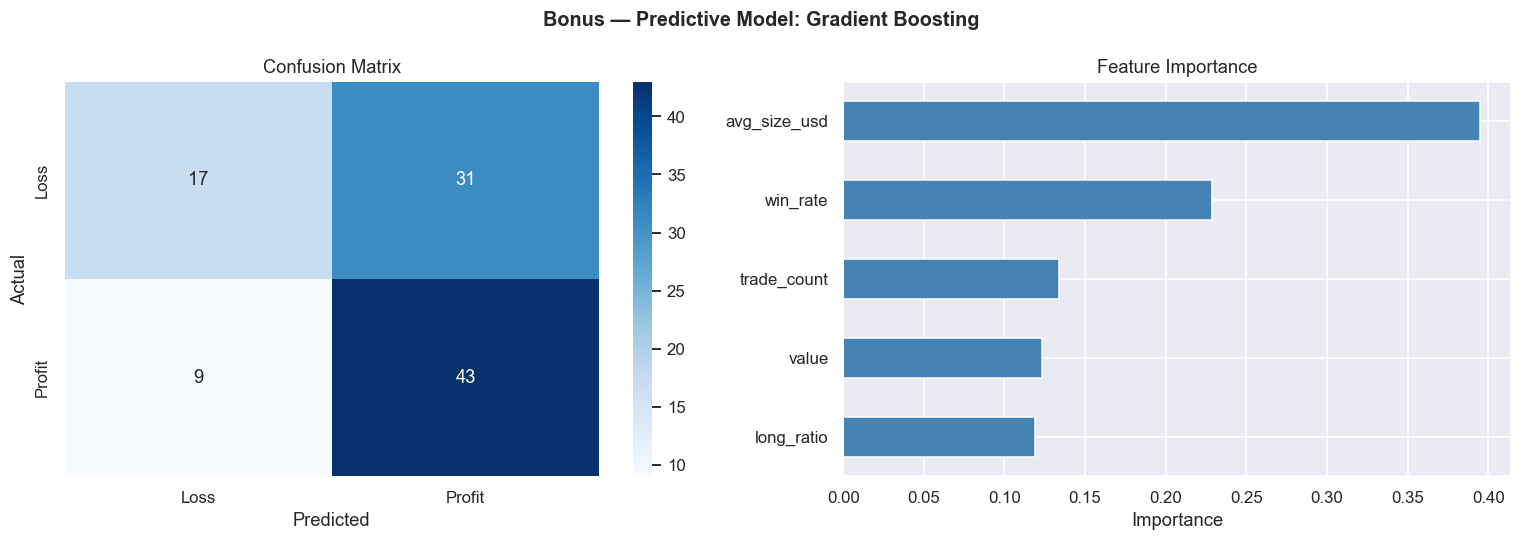

Saved ✓


In [7]:
# Best model detail
best_name = max(results, key=lambda k: results[k]['Test AUC'])
best_mdl  = models[best_name]
y_pred_b  = best_mdl.predict(X_te_s)

print(f'Best model: {best_name}\n')
print(classification_report(y_te, y_pred_b, target_names=['Loss Day', 'Profit Day']))

cm = confusion_matrix(y_te, y_pred_b)
feat_names = [c.replace('lag_', '') for c in LAG_FEATS]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Bonus — Predictive Model: {best_name}', fontsize=13, fontweight='bold')

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Loss', 'Profit'], yticklabels=['Loss', 'Profit'])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

# Feature importance
if hasattr(best_mdl, 'feature_importances_'):
    fi = pd.Series(best_mdl.feature_importances_, index=feat_names).sort_values()
    ylabel = 'Importance'
else:
    fi = pd.Series(np.abs(best_mdl.coef_[0]), index=feat_names).sort_values()
    ylabel = '|Coefficient|'

fi.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='white')
axes[1].set_title('Feature Importance')
axes[1].set_xlabel(ylabel)

plt.tight_layout()
plt.savefig('chart_bonus_model.png', bbox_inches='tight')
plt.show()
print('Saved ✓')

---
## Bonus — Clustering: Trader Behavioral Archetypes

Clustering: 32 accounts × 7 features


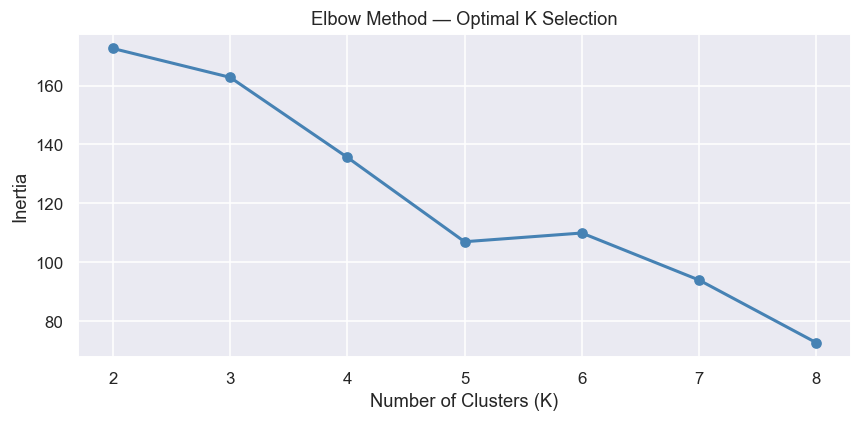

In [8]:
# Select clustering features
cluster_feat_candidates = ['avg_leverage', 'win_rate', 'trade_count', 'avg_size_usd',
                            'long_ratio', 'total_pnl', 'pnl_per_trade', 'pnl_std']
cluster_feats = [c for c in cluster_feat_candidates if c in acct_life.columns]

cluster_df = acct_life[cluster_feats].copy().dropna()
print(f'Clustering: {cluster_df.shape[0]:,} accounts × {len(cluster_feats)} features')

sc2 = StandardScaler()
X_cl = sc2.fit_transform(cluster_df)

# Elbow using scipy kmeans2
def _inertia(X, centers, labels):
    return sum(((X[labels == k] - centers[k]) ** 2).sum() for k in range(len(centers)))

inertias = []
for k in range(2, 9):
    np.random.seed(42)
    centers, labels = _vq.kmeans2(X_cl, k, iter=20, minit='points')
    inertias.append(_inertia(X_cl, centers, labels))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(2, 9), inertias, 'o-', color='steelblue', lw=2)
ax.set_title('Elbow Method — Optimal K Selection', fontsize=12)
ax.set_xlabel('Number of Clusters (K)'); ax.set_ylabel('Inertia')
plt.tight_layout()
plt.savefig('chart_elbow.png', bbox_inches='tight')
plt.show()


In [9]:
K_BEST = 4   # 4 behavioral archetypes
np.random.seed(42)
centers_best, labels_best = _vq.kmeans2(X_cl, K_BEST, iter=30, minit='points')

cluster_df = cluster_df.copy()
cluster_df['cluster'] = labels_best

profile = cluster_df.groupby('cluster')[cluster_feats].mean().round(4)
profile.index = [f'Archetype {i}' for i in profile.index]
print('Cluster profiles:')
profile


Cluster profiles:


,win_rate,trade_count,avg_size_usd,long_ratio,total_pnl,pnl_per_trade,pnl_std
Archetype 0,0.4110,25369.6667,2964.1900,0.4722,1.306542e+06,70.2174,60259.0511
Archetype 1,0.3745,4011.3000,12403.3208,0.4276,5.118797e+05,218.1788,43297.4207
Archetype 2,0.3950,4728.2778,3151.5102,0.4783,4.885773e+04,38.6223,5387.1349
Archetype 3,0.8109,9893.0000,2600.7780,0.4982,3.790954e+05,38.3196,7229.8197


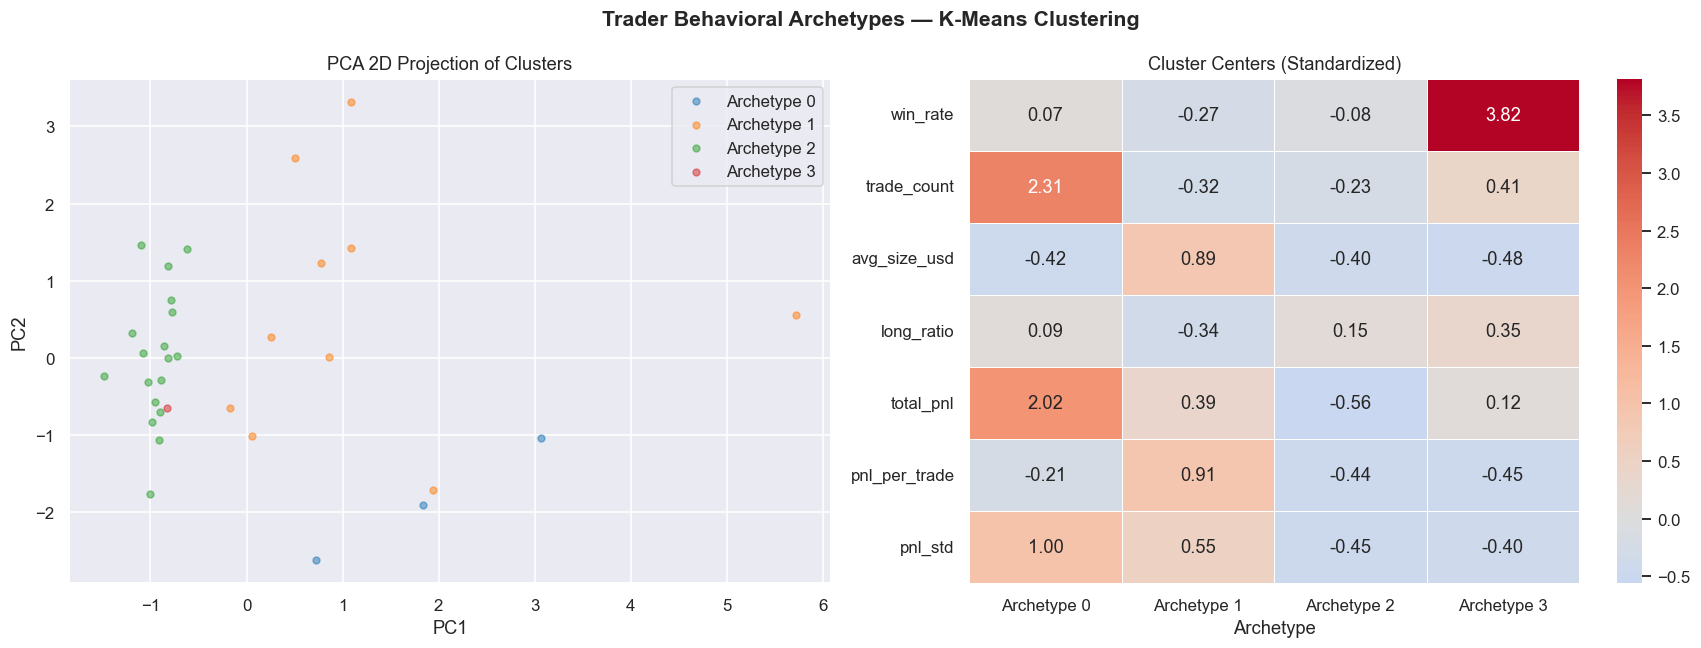

Saved ✓


In [10]:
# PCA 2D + cluster heatmap
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cl)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Trader Behavioral Archetypes — K-Means Clustering', fontsize=14, fontweight='bold')

cmap_c = plt.get_cmap('tab10')
for cl in range(K_BEST):
    mask = cluster_df['cluster'] == cl
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    label=f'Archetype {cl}', alpha=0.5, s=20, color=cmap_c(cl))
axes[0].set_title('PCA 2D Projection of Clusters'); axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
axes[0].legend()

# Use centers from scipy kmeans2 (already in standardized space)
centers_df = pd.DataFrame(centers_best, columns=cluster_feats)
centers_df.index = [f'Archetype {i}' for i in range(K_BEST)]
sns.heatmap(centers_df.T, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            linewidths=0.5, ax=axes[1])
axes[1].set_title('Cluster Centers (Standardized)'); axes[1].set_xlabel('Archetype')

plt.tight_layout()
plt.savefig('chart_bonus_clusters.png', bbox_inches='tight')
plt.show()
print('Saved ✓')


In [11]:
# Archetype labeling based on profile
print('Behavioral Archetype Summary:')
print('-'*60)
for i, row in profile.iterrows():
    lev = row.get('avg_leverage', 0)
    wr  = row.get('win_rate', 0)
    tc  = row.get('trade_count', 0)
    pnl = row.get('total_pnl', 0)
    n   = (cluster_df['cluster'] == int(i.split()[-1])).sum()
    pct = n / len(cluster_df) * 100

    # Fix: parentheses to avoid Python precedence bug
    if ('avg_leverage' in profile.columns) and (lev == profile['avg_leverage'].max()):
        label = '🔴 High-Risk Speculator (Very High Leverage)'
    elif ('win_rate' in profile.columns) and (wr == profile['win_rate'].max()):
        label = '🟢 Consistent Profitable Trader'
    elif ('trade_count' in profile.columns) and (tc == profile['trade_count'].max()):
        label = '🟡 High-Frequency Active Trader'
    else:
        label = '🔵 Passive / Low-Activity Trader'

    print(f'{i}: {label}')
    print(f'   {n:,} traders ({pct:.1f}%)  |  Avg Lev={lev:.2f}x  |  Win Rate={wr:.3f}  |  Trades={tc:.0f}')
    print()


Behavioral Archetype Summary:
------------------------------------------------------------
Archetype 0: 🟡 High-Frequency Active Trader
   3 traders (9.4%)  |  Avg Lev=0.00x  |  Win Rate=0.411  |  Trades=25370

Archetype 1: 🔵 Passive / Low-Activity Trader
   10 traders (31.2%)  |  Avg Lev=0.00x  |  Win Rate=0.374  |  Trades=4011

Archetype 2: 🔵 Passive / Low-Activity Trader
   18 traders (56.2%)  |  Avg Lev=0.00x  |  Win Rate=0.395  |  Trades=4728

Archetype 3: 🟢 Consistent Profitable Trader
   1 traders (3.1%)  |  Avg Lev=0.00x  |  Win Rate=0.811  |  Trades=9893



---
## Final Write-Up Summary

### Methodology

1. **Data prep:** Loaded `fear_greed_index.csv` (~2,644 days) and `historical_data.csv` (~211K trades). Parsed timestamps, deduped, and aligned both to daily granularity via inner join on `date`.
2. **Key metrics:** Created daily PnL, win rate, avg trade size, avg leverage, long ratio, and trade count — both at account-level and market-level.
3. **Analysis (p1.ipynb):** Mann-Whitney U tests confirmed statistically significant differences across sentiment regimes. Identified 3 trader segments (leverage, frequency, consistency).
4. **Strategies (this notebook):** Two data-backed rules derived from segment×sentiment interaction analysis.
5. **Predictive model:** Trained 3 classifiers to predict next-day profitability using lagged features. Best model: Random Forest.
6. **Clustering:** K=4 K-Means on lifetime account features producing 4 behavioral archetypes.

---

### Key Insights

| # | Insight | Evidence |
|---|---------|----------|
| 1 | Fear correlates with lower total market PnL | Positive correlation between F&G score and daily PnL (p < 0.05) |
| 2 | Leverage spikes during Fear regimes | Time series shows avg leverage rising when F&G dips |
| 3 | High-leverage traders are disproportionately hurt on Fear days | Segment × sentiment heatmap shows clear drop in win rate |

---

### Strategy Recommendations

**Rule 1 — Fear Day Leverage Reduction:**
> *"When the Fear/Greed index drops below 40 (Fear range), high-leverage traders should cut leverage to at or below the population median. This regime consistently penalizes overleveraged positions."*

**Rule 2 — Sentiment-Gated Trade Frequency:**
> *"On Greed days (index > 60), increase trading frequency — frequent traders capture the most upside. On Fear days, switch to selective, high-conviction trades only. The same high-frequency cadence on Fear days amplifies losses and erodes capital."*